In [ ]:
# The idea of this script is calculate size distrbutions of osm Features 
# of intresset is to calculate a distrbution for each key value pair that is 
# listed on the wikipages refrences in osm_groups.txt
# for this we will randomly querry the whole OSM dataset to collect samples

In [ ]:
# https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects

In [1]:
import parse_osm
from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, MultiPoint
from shapely.ops import transform
import random
import pandas as pd
import geopandas as gpd
import pyproj
import numpy as np
import fiona

In [2]:
def random_bb(size,constrain=None):
    # size has to be in degrees since to BB for osm is in degrees
    # constrain has to be a shapely (multi-)polygon and can be used to limit the area
    
    # if a constrain exist we shrink the possibility space donw to the bounds of it 
    if constrain:
        minx, miny, maxx, maxy = constrain.bounds
    else:
        minx, miny, maxx, maxy = -180,-90,180,90
    
    # we generate first the lower left corner of the bounding box
    if constrain:
        # when an constrain exist we make shure the point is within it
        ll_x,ll_y =-9999999,-9999999
        while not constrain.contains(Point(ll_x, ll_y)):
            ll_x,ll_y = random.uniform(minx, maxx),random.uniform(miny, maxy)
    else:
        ll_x,ll_y = random.uniform(minx, maxx),random.uniform(miny, maxy)
        
    
     
    return Polygon([(ll_x,ll_y),(ll_x+size,ll_y),(ll_x+size,ll_y+size),(ll_x,ll_y+size)])
    
    
def generate_tag_list(df):
    tag_list = []
    for row in df.iterrows():
        tag_list.append(f"{row[1]['key']} {row[1]['value']}")
    
    return tag_list


def filter_tags(row):
    # this function looks if key,value are present in the tag_list 
    # if so it returns true
    r_value = False
    if row['tags']:
        for key in row['tags'].keys():
            if f"{key} {row['tags'][key]}" in tag_list:
                 r_value = True
    return r_value


def line_length(line):
    
    geod = pyproj.Geod(ellps='WGS84')
    line_length = geod.geometry_length(line)

    return abs(line_length)


def poly_area(poly):

    geod = pyproj.Geod(ellps='WGS84')
    poly_area = geod.geometry_area_perimeter(poly)[0]
    
    return abs(poly_area)


def calcualte_size_for_tags(row):
    #print(row)
    geometry, tags  = row['geometry'], row['tags']
    sizes_dict = {}
    for key in geometry.keys():
        if 'line' in key:
            sizes_dict['length'] = line_length(geometry[key])
        elif 'poly' in key:
            sizes_dict['area'] = poly_area(geometry[key])
            
    # we only keep tag key combinations that are part of tag_list     
    key_val_list = [f'{key} {tags[key]}' for key in tags.keys() if f'{key} {tags[key]}' in tag_list]
    
    return_dict = {}
    
    # a geometry might have more than one relevant tag
    # {'tag_key':{'length':,'area':},'tag_key2':{'length':,'area':}}
    for key_val in key_val_list:
        return_dict[key_val] = sizes_dict

    return return_dict


def flip_xy(x,y):
    return y,x


def agg_len_area(x):
    length = [el for el in x['length'].tolist() if el]
    area = [el for el in x['area'].tolist() if el]
    
    return pd.Series({'area':area,'length':length}, index=['area', 'length'])

In [3]:
# Setup parameters
# this sets how many itterations we will go for 
n_iter = 10

# we can define an area in which we ware looking for key value combinations
# if this is not supplied the whole world will be querried
# polygon can be arbitrarie (must be in degrees) but only the lower left corner of the random bounding box
# is quaranteete to be within the polygon
#q_poly = Polygon([(52.450425727741,13.286182880402),(52.458323725344,13.286182880402),(52.458323725344,13.299744129181),(52.450425727741,13.299744129181)])
level_1_admin = gpd.read_file("../data/shapes/level_1_admin/ne_10m_admin_1_states_provinces.shp")
# in this case we select vienna as the polyon
q_poly  = level_1_admin[level_1_admin['name']=='Wien']['geometry'].iloc[0]
# x,y need to be fliped because in the loaded shape x == lon y == lat 
# but overpass wants this to be the other way around
# q_poly
# here we define the size of our random bounding box in degrees
# 0.001° =111 m
bb_size = 0.005

# now we load the predefined tags from pickle
tag_df =  pd.read_pickle('./kv_df_just_eng.pickle')
tag_list = generate_tag_list(tag_df)

# we need the results_df to collect all the values
results_df = pd.DataFrame(columns=['key','value','area','length']) 

In [ ]:
list(q_poly.exterior.coords)[:10]

In [ ]:
q_poly

In [5]:
for i in range(n_iter):
    r_bb = random_bb(bb_size,q_poly)
    # we use the generated polygon to querry osm for all features within the bounding box
    osm_handle = parse_osm.disect_osm(parse_osm.json_from_osm(r_bb))

    # and filter the querried polygons for a) if a tag from the tag_list is pressent and b) if they are not just a point 
    selected_geom_df = osm_handle.feature_df[(osm_handle.feature_df.apply(filter_tags, axis= 1)) & (osm_handle.feature_df['type'] != 'node')] 
    type_id_list = selected_geom_df[['type','id']].values.tolist()
    # for the selected features we calculate the geometry:
    [osm_handle.generate_geometry(f_type,osm_id) for f_type, osm_id in type_id_list]
    # and reselect them
    selected_geom_df = osm_handle.feature_df[(osm_handle.feature_df.apply(filter_tags, axis= 1)) & (osm_handle.feature_df['type'] != 'node')]

    # for these selected feature we calcuate where aplicable either are or length or both
    # and then split them into thier key value pairs
    if len(selected_geom_df) > 0:
        for element in selected_geom_df[['geometry','tags']].apply(calcualte_size_for_tags,axis=1).tolist():

            for key_val in element.keys():
                key,value = key_val.split(' ')
                _dict = {'key':key,'value':value,'area':element[key_val].get('area'),'length':element[key_val].get('length')}
                results_df = results_df.append(_dict,ignore_index=True)

        # making shure everything that needs to be pyton None is None
        results_df = results_df.where(pd.notnull(results_df), None)

    print(f'finished iteration {i} so far we grabbed {len(results_df)} features')
    
# here we group the differen key value pairs together with the values we fetched from OSM
results_grouped_df = results_df.groupby(['key','value']).apply(agg_len_area)

finished iteration 0 so far we grabbed 469 features


TypeError: 'LineString' object is not subscriptable

In [7]:
list(r_bb.exterior.coords)

[(16.270485370522998, 48.24588384315554),
 (16.275485370522997, 48.24588384315554),
 (16.275485370522997, 48.25088384315554),
 (16.270485370522998, 48.25088384315554),
 (16.270485370522998, 48.24588384315554)]

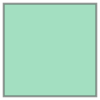

In [6]:
r_bb

In [ ]:
results_grouped_df.to_pickle('./tag_sizes_df.pickle')
results_grouped_df

In [ ]:
import ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, WKTLayer
from ipywidgets import Label

# osmid = test.feature_df[test.feature_df['type']=='relation'].sample().iloc[0]['id']
# test_multi = test.generate_geometry('relation',osmid)

m = Map(
    basemap=basemaps.CartoDB.Positron,
    # for some reason lat lon are switch for centering the map
    center=(r_bb.centroid.coords[0][1],r_bb.centroid.coords[0][0]),
    zoom=14
)

wlayer = WKTLayer(
    wkt_string=r_bb.wkt,
    #hover_style={"fillColor": "red"},
    fill_color="red",
    color="red",
)


m.add_layer(wlayer)
m